In [1]:
import torch
from basic_unet import UNet
from dataset import BratsDataset
from torchvision import transforms
from pathlib import Path
import hdm
from plot_utils import plot_image_row

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = UNet(in_channels=4, out_channels=1)
state_dict = torch.load('models/3_basic_unet_flat_criterion_279_0.00000.pth')
model.load_state_dict(state_dict)
model = model.to(device)
transform = transforms.Compose([
    transforms.Normalize([0.5, 0.5, 0.5, 0.5], [0.5, 0.5, 0.5, 0.5])
])
dataset = BratsDataset(Path('data/processed/'), transform)

In [3]:
explainer = hdm.HausdorffDistanceMasks(240, 240)
explainer.generate_masks(circle_size=20, offset=5, normalize=True)

Masked image


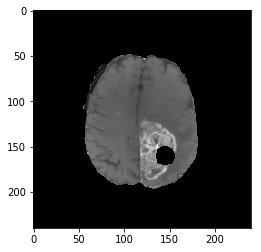

Output segment


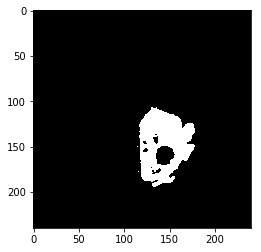

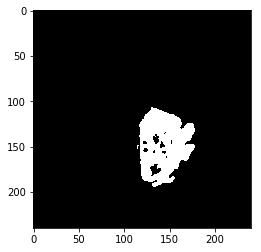

Difference to unchanged output


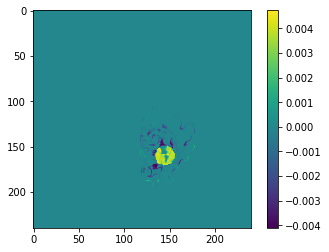

In [4]:
sample = dataset.get_sample('Brats18_TCIA08_242_1/', 'L2')
image = sample['input']
output = model(image.to(device).unsqueeze(0)).detach().cpu().squeeze()


def show_masked_difference(mask_x, mask_y):
    channel = 1
    masked_image = image.clone()
    masked_image[channel] = explainer.apply_mask(image[channel], explainer.masks[mask_x][mask_y])

    output_masked = model(masked_image.unsqueeze(0).to(device)).detach().cpu().squeeze()
    difference = output - output_masked

    print('Masked image')
    plot_image_row([masked_image[channel]], color_map='gray', colorbar=False)
    print('Output segment')
    plot_image_row([output_masked > output_masked.mean()], color_map='gray', colorbar=False)
    plot_image_row([output > output.mean()], color_map='gray', colorbar=False)
    print('Difference to unchanged output')
    plot_image_row([difference], colorbar=True)


show_masked_difference(30, 27)